# Evaluation
- EGNN generated ~60% higher binding affinity, but SE3 Transformer only ~0.04%. But SE3T obtained better CNN scores
   - This could be because the stretch of egnn generated mols are small, i.e., the atoms stay closely around the center.
   - SE3 Transformer generated normal stretch but we haven't manage to generate candidates with better binding affinity so far.
   - Actually SE3T might generate atoms too distant, so that during reconstruction they are not regarded as connected

In [1]:
import pandas as pd 
import numpy as np
import os
from math import ceil
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem.rdForceFieldHelpers import UFFOptimizeMolecule
import re
from collections import defaultdict

In [2]:
import py3Dmol
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

In [3]:
import sys
sys.path.append('../evaluation/')

In [4]:
from utils_eval import build_pdb_dict

## MSE loss

In [51]:
bridge_type = 'vp'

# egnn
# fixed point init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_45.077216'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_53.688104'
# Gaussian noise init
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_04_23.779433'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-06-17_23_06_28.209248'

# transformer
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-06-01_21_36_34.208973'
# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-05-31_23_42_37.443630'

# root_path = '../lightning_logs/vp_bridge_CombinedSparseGraphDataset_2024-06-18_14_36_42.924053'
# root_path = '../lightning _logs/vp_bridge_CombinedSparseGraphDataset_2024-06-18_14_37_44.491071'

# only basic

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_28.164795'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-19_14_29_44.297462'

# basic + aromatic

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_02_24_30.913781'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-20_13_18_12.746286'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-21_23_58_36.562980'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_40_53.679692'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-01_11_35_53.861210'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-31_22_41_26.883181'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-17_16_46_56.979357'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-20_13_01_03.604652'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_13_30_50.133260'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916'

# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_13_30_50.133260/ligand_based/selected'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_13_30_50.133260/selected'
root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916/ligand_based/selected'
# root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-08-19_21_05_04.140916/selected'


aromatic = True
# log_path = '../../docking_res/logs/' + bridge_type

In [17]:
# bridge_type = 've'

# # egnn
# # root_path = '../lightning_logs/ve_bridge_egnn_CombinedSparseGraphDataset_2024-05-31_14_11_42.795058'
# root_path = '../lightning_logs/ve_bridge_egnn_CombinedSparseGraphDataset_2024-05-30_23_27_52.002393'

# aromatic = False

## CE/NLL loss

In [28]:
# bridge_type = 'vp'

# # egnn
# # fixed point init
# # root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_44_27.850031'
# # root_path = '../lightning_logs/vp_bridge_egnn_CombinedSparseGraphDataset_2024-07-02_02_43_48.858042'


# aromatic = False

In [52]:
log_path = os.path.join(root_path, 'logs')
log_path = log_path+'_aromatic' if aromatic else log_path
gen_path = os.path.join(root_path, 'reconstructed_mols')
gen_path = gen_path+'_aromatic_mode' if aromatic else gen_path

optimization = True
gen_path = gen_path + '_optimized' if optimization else gen_path
log_path = log_path + '_optimized' if optimization else log_path

raw_data_path = '../../data/cleaned_crossdocked_data/raw'

log_files = os.listdir(log_path)
pdb_dict, pdb_rev_dict = build_pdb_dict(raw_data_path)

In [53]:
len(log_files)

5869

In [54]:
def get_minimized_affinity(filename, mode='ref'):
    if mode == 'ref':
        with open(filename, 'r') as file:
            for line in file:
                if '<minimizedAffinity>' in line:
                    # The next line after '<minimizedAffinity>' contains the value
                    return float(next(file))
            
    else:
        with open(filename, 'r') as f:
            lines = f.readlines()
            lines = lines[19:28]
#             print(len(lines))
            n = len(lines)
            arr = np.zeros(n)
            cnn_arr = np.zeros(n)
#             print(filename)
            for i in range(n):
                arr[i] = float(lines[i][11:17])
                cnn_arr[i] = float(lines[i][34:42])
#             print(arr)
            try:
                score = np.min(arr)
                cnn_score = np.min(cnn_arr)
            except:
                score = None
                cnn_score = None
                print(f'{filename} failed')
                print('its scores: ', arr)
        return score, cnn_score

In [55]:
def get_affinity_best_pose(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = lines[19:28]
        try:
            score = float(lines[0][11:17])
            cnn_score = float(lines[0][34:42])
            # cnn_score = float(lines[0][24:30])
        except:
            score = None
            cnn_score = None
        return score, cnn_score

In [56]:
score_dict = {}
for log_file in tqdm(log_files):
    ligand_name = log_file.split('.')[0]
    ligand_file = ligand_name + '.sdf'
    pdb_folder = pdb_rev_dict[ligand_file]
    ref_file = os.path.join(raw_data_path, pdb_folder, ligand_file)
    ref_score = get_minimized_affinity(ref_file, 'ref')
#     print(log_file)
    gen_score, cnn_score = get_minimized_affinity(os.path.join(log_path, log_file), 'gen')
    # gen_score, cnn_score = get_affinity_best_pose(os.path.join(log_path, log_file))
    score_dict[ligand_name] = [gen_score, cnn_score, ref_score]

100%|███████████████████████████████████████████████████████████████████████| 5869/5869 [00:00<00:00, 16192.78it/s]


In [57]:
df = pd.DataFrame.from_dict(score_dict, orient='index', columns=['Binding affinity', 'CNN score', 'Reference'])
df

,Binding affinity,CNN score,Reference
3nz9_X_rec_4ixf_ixf_lig_tt_docked_0,-6.71,0.6314,-9.99601
4zsh_A_rec_4k4j_1o8_lig_tt_min_0,-7.91,0.4117,-11.20360
3d90_B_rec_1a28_str_lig_tt_docked_4,-8.21,0.6818,-7.99992
4owm_A_rec_4n5v_fa0_lig_tt_min_0,-5.24,0.5740,-5.98217
3nvy_C_rec_3bdj_141_lig_tt_min_0,-1.78,0.5426,-5.68836
...,...,...,...
5bzf_A_rec_5bze_68n_lig_tt_min_0,-4.66,0.5078,-4.47019
1vdv_A_rec_3am9_fyo_lig_tt_min_0,-6.34,0.4526,-9.71778
4ebv_A_rec_4ebw_0pf_lig_tt_min_0,-8.33,0.3238,-10.56623
4xma_A_rec_4xhb_17y_lig_tt_min_0,-3.78,0.6185,-4.04633


In [58]:
filtered_df = df.loc[df['Binding affinity']<df['Reference']]
filtered_df

,Binding affinity,CNN score,Reference
3d90_B_rec_1a28_str_lig_tt_docked_4,-8.21,0.6818,-7.99992
3kwy_A_rec_4zsh_4xw_lig_tt_min_0,-7.94,0.5406,-7.84417
5iu6_A_rec_3occ_dih_lig_tt_min_0,-7.02,0.3690,-5.74801
4s23_A_rec_4s3d_dpo_lig_tt_docked_9,-6.86,0.8625,-6.00956
1v97_B_rec_3eub_xan_lig_tt_min_0,-7.17,0.6822,-6.35708
...,...,...,...
3jyh_A_rec_3n0t_opy_lig_tt_min_0,-6.11,0.5828,-5.05443
5ehq_A_rec_2whq_hi6_lig_tt_min_0,-6.15,0.6629,-5.53995
5uvy_A_rec_5uev_88y_lig_tt_docked_9,-6.62,0.2869,-6.10196
5bzf_A_rec_5bze_68n_lig_tt_min_0,-4.66,0.5078,-4.47019


In [59]:
sorted_df = filtered_df.sort_values(by='CNN score', ascending=False)
sorted_df

,Binding affinity,CNN score,Reference
5xin_A_rec_5xim_sor_lig_tt_docked_6,-7.36,0.9070,-6.56085
4gna_A_rec_4gn8_aso_lig_tt_min_0,-6.25,0.9026,-6.21091
4gh0_A_rec_4h2z_mys_lig_tt_min_0,-7.44,0.8869,-5.47220
4zp2_A_rec_4zow_clm_lig_tt_docked_3,-6.89,0.8846,-6.72317
5xin_A_rec_1xin_xyl_lig_tt_min_0,-6.47,0.8799,-6.36995
...,...,...,...
4xyx_A_rec_4xjw_opx_lig_tt_min_0,-6.27,0.0960,-5.88718
5jn9_B_rec_5jn9_ezl_lig_tt_min_0,-5.80,0.0950,-5.23913
4xjw_A_rec_4xma_opx_lig_tt_min_0,-6.42,0.0890,-6.25588
4xjw_A_rec_4xjw_opx_lig_tt_min_0,-6.65,0.0872,-6.23364


In [60]:
ba_res_filename = os.path.join(root_path, 'binding_affinity')
ba_res_filename = ba_res_filename+'_aromatic.csv' if aromatic else ba_res_filename+'.csv'

sorted_df.to_csv(ba_res_filename)

In [61]:
sum(df['Binding affinity'] < df['Reference']) / len(df)

0.3087408417106833

In [62]:
lig_fns = list(score_dict.keys())
# lig_fns

## gather by lig

In [62]:
all_lig = list(set([fn[fn.rfind('rec')+9:fn.rfind('rec')+12] for fn in lig_fns]))
len(all_lig)

400

In [63]:
def gather_BA(score_dict):
    lig_fns = list(score_dict.keys())
    # all_lig = list(set([fn[fn.rfind('rec')+9:fn.rfind('rec')+12] for fn in lig_fns]))
    gathered = defaultdict(lambda: {'BA':[], 'CNN':[], 'Ref':[]})
    for fn in tqdm(lig_fns):
        lig = fn[fn.rfind('rec')+9:fn.rfind('rec')+12]
        gathered[lig]['BA'].append(score_dict[fn][0])
        gathered[lig]['CNN'].append(score_dict[fn][1])
        gathered[lig]['Ref'].append(score_dict[fn][2])

    return gathered

In [64]:
gathered = gather_BA(score_dict)
# gathered
len(gathered)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5562/5562 [00:00<00:00, 1155630.79it/s]


400

In [22]:
def high_ratio(gathered):
    res = defaultdict(lambda: {'high BA ratio':0, 'avg CNN':0, 'num sample':0})
    for lig, v in gathered.items():
        ba_scores = np.array(v['BA'])
        cnn_scores = np.array(v['CNN'])
        ref_ba_scores = np.array(v['Ref'])
        assert len(ba_scores) == len(cnn_scores) == len(ref_ba_scores)
        n_sample = len(ba_scores)
        comparisons = np.less(ba_scores, ref_ba_scores)
        ratio = np.sum(comparisons) / n_sample
        avg_cnn = np.mean(cnn_scores)
        res[lig]['high BA ratio'] = ratio
        res[lig]['avg CNN'] = avg_cnn
        res[lig]['num sample'] = n_sample

    return res

In [66]:
res = high_ratio(gathered)
# res

In [67]:
res_df = pd.DataFrame.from_dict(res, orient='index')
res_df

,high BA ratio,avg CNN,num sample
1o8,0.019608,0.250059,51
4ew,0.000000,0.179300,10
str,0.275862,0.358862,29
29v,0.121212,0.166412,33
3sv,0.086957,0.189196,23
...,...,...,...
ccb,0.000000,0.490700,1
1s3,0.000000,0.182600,1
1ns,0.000000,0.428700,1
pp9,0.000000,0.124500,1


In [68]:
sorted_res_df = res_df.sort_values(by='high BA ratio', ascending=False)
sorted_res_df

,high BA ratio,avg CNN,num sample
hce,1.0,0.330143,7
93g,1.0,0.170233,3
mv1,1.0,0.476700,1
n_l,1.0,0.573033,3
2lx,1.0,0.427100,11
...,...,...,...
p1a,0.0,0.116160,5
8o4,0.0,0.222850,36
r18,0.0,0.450767,18
kmp,0.0,0.262033,6


In [69]:
res_filename = os.path.join(root_path, 'high_BA_ratio')
res_filename = res_filename+'_aromatic.csv' if aromatic else res_filename+'.csv'

sorted_res_df.to_csv(res_filename)

# gather by rec

In [69]:
all_rec = list(set([fn[fn.rfind('rec')+4:fn.rfind('lig')-1] for fn in lig_fns]))
len(all_rec)

450

In [70]:
all_rec

['4zg9_4o2',
 '1e8g_fcr',
 '5fe2_5wv',
 '2ivi_acw',
 '2w1a_tsa',
 '4gh1_0wx',
 '3ns1_pm6',
 '4s15_4d8',
 '2w8y_486',
 '3gsm_vpu',
 '1k27_mtm',
 '1xvp_f15',
 '4ixe_ixe',
 '2jge_pge',
 '1hgj_amn',
 '1n83_clr',
 '5bzc_4wt',
 '5mkx_82i',
 '1g9t_5gp',
 '4b84_z5k',
 '4x2p_3py',
 '5ijs_5jk',
 '1k9s_fm2',
 '4i4e_1bq',
 '1h83_dia',
 '4fbt_gtp',
 '3ki5_g9m',
 '3ex8_aif',
 '4rme_3t2',
 '3etr_luz',
 '5fe8_5wt',
 '3sms_rnh',
 '1ix1_bb2',
 '4q4o_2ym',
 '4x8d_avi',
 '4mrf_2ck',
 '4qqd_36x',
 '1ecm_tsa',
 '5jgm_810',
 '3bdj_141',
 '4xhl_cki',
 '4jc5_1k5',
 '4gg7_0j8',
 '3nbq_urf',
 '2xg5_ec2',
 '5i00_afq',
 '5tb6_77x',
 '1dtl_bep',
 '2evs_hex',
 '3p1d_mb3',
 '4g9p_cdi',
 '4gh3_0ev',
 '5h4i_7hq',
 '3rfm_cff',
 '4rmc_3sv',
 '3lsw_4mp',
 '5iu6_7hx',
 '1xin_xyl',
 '1n5x_tei',
 '4m8h_r4m',
 '2buq_caq',
 '1cgz_stl',
 '4h2z_mys',
 '1cgk_nar',
 '2ei1_d1n',
 '5fjv_epj',
 '1w1v_alj',
 '2buu_4nc',
 '4mzg_mrd',
 '5eub_5s7',
 '1w1p_gio',
 '4d58_bi9',
 '4ebw_0pf',
 '1e3k_r18',
 '3tku_m77',
 '5eih_tz2',
 '4zyr_9pg',

In [73]:
def gather_BA_rec(score_dict):
    lig_fns = list(score_dict.keys())
    # all_lig = list(set([fn[fn.rfind('rec')+9:fn.rfind('rec')+12] for fn in lig_fns]))
    gathered = defaultdict(lambda: {'BA':[], 'CNN':[], 'Ref':[]})
    for fn in tqdm(lig_fns):
        lig = fn[fn.rfind('rec')+4:fn.rfind('lig')-1]
        gathered[lig]['BA'].append(score_dict[fn][0])
        gathered[lig]['CNN'].append(score_dict[fn][1])
        gathered[lig]['Ref'].append(score_dict[fn][2])

    return gathered

In [74]:
gathered_rec = gather_BA_rec(score_dict)
# gathered_rec
len(gathered_rec)

100%|██████████████████████████████████████████████████████████████████████| 5869/5869 [00:00<00:00, 873695.48it/s]


450

In [75]:
res_rec = high_ratio(gathered_rec)
res_df_rec = pd.DataFrame.from_dict(res_rec, orient='index')
res_df_rec

,high BA ratio,avg CNN,num sample
4ixf_ixf,0.033333,0.481637,30
4k4j_1o8,0.000000,0.288061,51
1a28_str,0.214286,0.514536,28
4n5v_fa0,0.384615,0.533105,39
3bdj_141,0.300000,0.544700,20
...,...,...,...
4zyr_9pg,0.000000,0.594350,2
1sv2_dtt,1.000000,0.446600,1
2xg5_ec2,0.000000,0.332700,1
1u3t_ccb,1.000000,0.491000,1


In [76]:
sorted_res_df_rec = res_df_rec.sort_values(by='high BA ratio', ascending=False)
sorted_res_df_rec

,high BA ratio,avg CNN,num sample
1ah0_sbi,1.0,0.495000,1
1j06_ae3,1.0,0.644971,24
1h83_dia,1.0,0.598118,11
2vx3_p6g,1.0,0.664700,1
5fe7_5wu,1.0,0.426450,2
...,...,...,...
4oar_2s0,0.0,0.544750,2
4kq2_u5p,0.0,0.387800,1
1b8n_img,0.0,0.222205,20
4qqd_36x,0.0,0.290550,2


In [77]:
res_filename_rec = os.path.join(root_path, 'high_BA_ratio_rec')
res_filename_rec = res_filename_rec+'_aromatic.csv' if aromatic else res_filename_rec+'.csv'

sorted_res_df_rec.to_csv(res_filename_rec)

# check specific sample

In [25]:
def test_ref_ligand(ligand, path=gen_path, raw_path=raw_data_path, pdb_rev_dict=pdb_rev_dict):
    example = os.path.join(path, ligand+'.sdf')
    m = Chem.MolFromMolFile(example)
    # m = Chem.AddHs(m)

    pdb_folder = pdb_rev_dict[ligand+'.sdf']
    ref_file = os.path.join(raw_path, pdb_folder, ligand+'.sdf')
    ref_m = Chem.MolFromMolFile(ref_file)
    return m, ref_m

In [17]:
lig = '1kre_A_rec_1krf_kif_lig_tt_min_0'

In [19]:
pdb_rev_dict[lig+'.sdf']

'MAN12_PENCI_36_511_0'

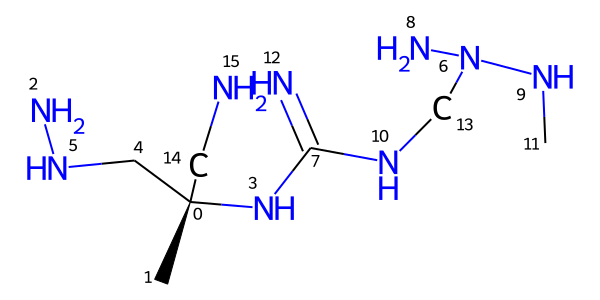

In [20]:
m, ref_m = test_ref_ligand(lig) 
m

[11:16:07] Molecule does not have explicit Hs. Consider calling AddHs()


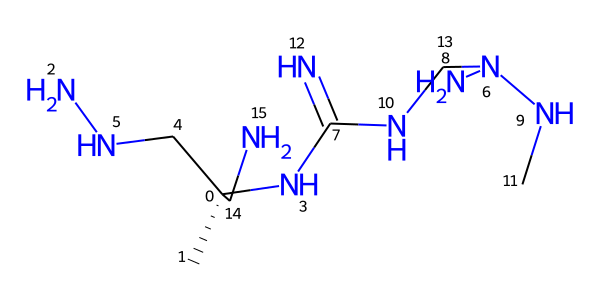

In [21]:
# m = Chem.AddHs(m, addCoord=True)
UFFOptimizeMolecule(m)
m

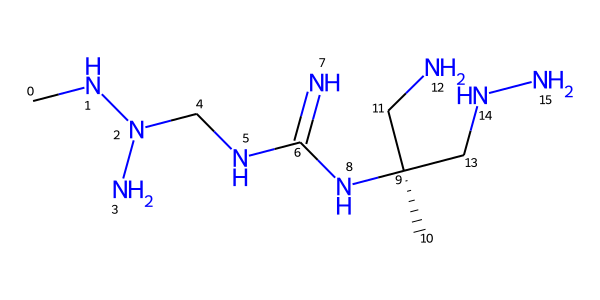

In [22]:
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m))
m_2d

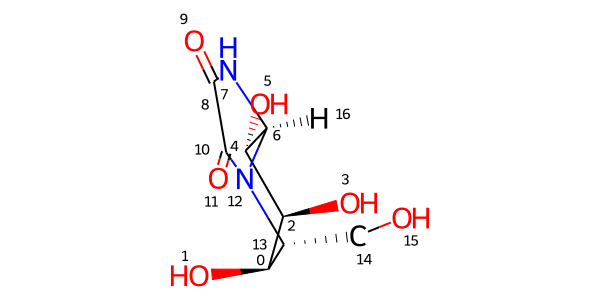

In [23]:
ref_m

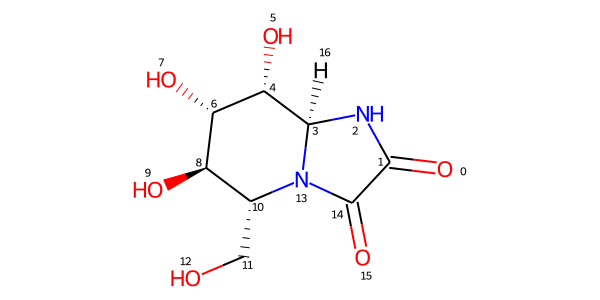

In [24]:
ref_m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(ref_m))
ref_m_2d

In [25]:
def viz(ligand, path=gen_path):
    example = os.path.join(path, ligand+'.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(example).read())
    v.setStyle({'model':0},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    
    return v

In [26]:
viz(lig)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [27]:
def viz_with_pr(ligand, root_path=root_path, raw_data_path=raw_data_path, pdb_rev_dict=pdb_rev_dict, aromatic=True):
    # example = os.path.join(path, ligand+'.sdf')

    pattern = r"(\w+_[A-Z]_rec)"
    match = re.search(pattern, ligand)
    pdb_folder = pdb_rev_dict[ligand + '.sdf']
    pr_pdb = match.group(1)
    print(pr_pdb)
    protein_file = os.path.join(raw_data_path, pdb_folder, pr_pdb + '.pdb')

    ligand_fn = ligand[ligand.rfind('rec')+4:ligand.rfind('lig')+3]

    autobox_ligand_file = os.path.join(raw_data_path, pdb_folder, ligand_fn + '.pdb')

    out_folder = 'output_aromatic' if aromatic else 'output'
    out_file = os.path.join(root_path, out_folder, ligand + '.sdf')
    # out_file = os.path.join('../../', ligand + '.sdf')
    
    v = py3Dmol.view()
    v.addModel(open(protein_file).read())
    v.setStyle({'cartoon':{},'stick':{'radius':.1}})
    v.addModel(open(autobox_ligand_file).read())
    v.setStyle({'model':1},{'stick':{'colorscheme':'dimgrayCarbon','radius':.125}})
    v.addModelsAsFrames(open(out_file).read())
    v.setStyle({'model':2},{'stick':{'colorscheme':'greenCarbon','radius':.125}})
    v.zoomTo({'model':1})
    v.rotate(90)
    v.animate({'interval':1000})
    
    return v

In [28]:
viz_with_pr(lig, aromatic=aromatic)

1kre_A_rec


3Dmol.js failed to load for some reason. Please check your browser console for error messages.